# Project: Single Index Models and the Capital Allocation Line
In the worked example for this module, we compared data-driven and single-index models portfolio allocation for a basket of risky assets. Now, let's consider the case in which our portfolio can have both risk-free and risky assets. 

### Learning objectives
The objective of this project is to compute the expected return vector $\mathbb{E}(R_{i})$ and the covariance matrix $\mathbf{\Sigma}$ using the single index models, where we use `SPY` as the market, or benchmark, portfolio. Using these quantities, you'll explore the portfolio allocation problem for combinations of risky and risk-free assets.

* __Prerequisites__: we'll begin by loading the historical dataset. The data we'll explore is daily open-high-low-close values for firms in the [S&P500 index](https://en.wikipedia.org/wiki/S%26P_500) between `01-03-2018` and `12-29-2023`.
* __Task 1__: We'll compute the expected returns and the covariance arrays using the single index models
* __Task 2__: We'll compute the efficient frontier by solving the minimum variance optimization problem for the single index model formulation for the low-correlation collection of risky assets.
* __Task 3__: Finally, you'll compute the capital allocation line and the tangent portfolio using the single index models and look at what is inside your tangent portfolio.

## Setup
We set up the computational environment by including the `Include.jl` file. The `Include.jl` file loads external packages, various functions that we will use in the exercise, and custom types to model the components of our lab problem.
* For additional information on functions and types used in this material, see the [Julia programming language documentation](https://docs.julialang.org/en/v1/) and the [VLQuantitativeFinancePackage.jl documentation](https://github.com/varnerlab/VLQuantitativeFinancePackage.jl). 

In [3]:
include("Include.jl");

## Prerequisites: Load and clean the historical dataset
We gathered a daily open-high-low-close `dataset` for each firm in the [S&P500](https://en.wikipedia.org/wiki/S%26P_500) since `01-03-2018` until `12-29-2023`, along with data for a few exchange-traded funds and volatility products during that time. We load the `orignal_dataset` by calling the [load(...) method exported by the JLD2.jl package](https://github.com/JuliaIO/JLD2.jl.git).

In [5]:
original_dataset = load(joinpath(_PATH_TO_DATA, "SP500-Daily-OHLC-1-3-2018-to-12-29-2023.jld2")) |> x-> x["dataset"];

### Clean the data
Not all of the tickers in our dataset have the maximum number of trading days for various reasons, e.g., acquistion or de-listing events. Let's collect only those tickers with the maximum number of tradition days.

* First, let's compute the number of records for a company that we know has a maximim value, e.g., `AAPL` and save that value in the `maximum_number_trading_days` variable:

In [7]:
maximum_number_trading_days = original_dataset["AAPL"] |> nrow;

Next, iterate through our data and collect only tickers with `maximum_number_trading_days` records. Save that data in the `dataset::Dict{String,DataFrame}` variable:

In [9]:
dataset = Dict{String,DataFrame}();
for (ticker,data) ∈ original_dataset
    if (nrow(data) == maximum_number_trading_days)
        dataset[ticker] = data;
    end
end
dataset

Dict{String, DataFrame} with 460 entries:
  "NI"   => 1508×8 DataFrame…
  "EMR"  => 1508×8 DataFrame…
  "CTAS" => 1508×8 DataFrame…
  "HSIC" => 1508×8 DataFrame…
  "KIM"  => 1508×8 DataFrame…
  "PLD"  => 1508×8 DataFrame…
  "IEX"  => 1508×8 DataFrame…
  "BAC"  => 1508×8 DataFrame…
  "CBOE" => 1508×8 DataFrame…
  "EXR"  => 1508×8 DataFrame…
  "NCLH" => 1508×8 DataFrame…
  "CVS"  => 1508×8 DataFrame…
  "DRI"  => 1508×8 DataFrame…
  "DTE"  => 1508×8 DataFrame…
  "ZION" => 1508×8 DataFrame…
  "AVY"  => 1508×8 DataFrame…
  "EW"   => 1508×8 DataFrame…
  "EA"   => 1508×8 DataFrame…
  "NWSA" => 1508×8 DataFrame…
  "CAG"  => 1508×8 DataFrame…
  "GPC"  => 1508×8 DataFrame…
  "FCX"  => 1508×8 DataFrame…
  "GILD" => 1508×8 DataFrame…
  "UNP"  => 1508×8 DataFrame…
  "CDW"  => 1508×8 DataFrame…
  ⋮      => ⋮

Let's get a sorted list of firms that we have in cleaned up `dataset`, and save it in the `list_of_all_tickers` array:

In [11]:
list_of_all_tickers = keys(dataset) |> collect |> sort;

Finally, let's set some constant values, e.g., a value for the `risk_free_rate` and the $\Delta{t}$ value (1-trading day in units of years):

In [13]:
risk_free_rate = 0.0389; # continuous compounded risk-free rate (units: 1/yr)
Δt = (1.0/252); # 1-trading day (units: years)

### Compute the covariance and expected return for all firms in the dataset
The expected return $\mathbb{E}(r_{i})$ and covariance matrix $\Sigma$ will be used in our calculations, so we'll provide values for both of these items for the entire data set (all `N = 460` tickers), and then you can pick out which tickers you are interested in. 

* First, we compute the expected (annualized) log return by passing the `dataset` and the entire list of firms we have in the dataset (held in the $N\times{1}$ `list_of_all_tickers` array) to the [log_growth_matrix(...) method](https://varnerlab.github.io/VLQuantitativeFinancePackage.jl/dev/equity/#VLQuantitativeFinancePackage.log_growth_matrix). The result is stored in the `all_firms_return_matrix` variable, a $T-1\times{N}$ array of log return values. Each row of `all_firms_return_matrix` corresponds to a time value, while each column corresponds to a firm:

In [15]:
all_firms_excess_return_matrix = log_growth_matrix(dataset, list_of_all_tickers, 
    Δt = Δt, risk_free_rate = risk_free_rate) # one-trading day Δt

1507×460 Matrix{Float64}:
  0.336088   1.89038     6.98879   …   5.76269     1.75992    2.01562
  2.15097   -0.657039    3.98147       3.96778    -0.750836   2.937
  0.897421  -1.95507    -0.842654      2.86038    -0.394878   2.43031
  6.16272    1.47313    -1.90992       6.56668     5.1095     3.37483
 -3.51528    4.88241    -0.306577      1.77612     3.328     -4.90903
 -0.36462   10.2428      2.76778   …  10.6928      2.20144    2.44313
  3.26779    9.92523     7.33219       5.82065     2.35812    3.11215
 -0.208597   1.24649    -1.55764       2.68177    -1.59373    1.0681
  1.65959   -0.294763    1.91961       0.400949   -0.140935   2.80741
  0.1744     0.0990042  -0.522502     -0.199756   -0.544464  -1.12981
  2.97962   -1.0158      3.82748   …  -0.0867694   2.25035    0.953927
  0.874309  -0.725771    0.961274      0.243296    1.8525     1.44534
  1.06706    0.0580966   1.8466        2.42106     1.36853    1.7907
  ⋮                                ⋱                         
  6.8

Next, estimate the expected excess return for each firm from the `all_firms_excess_return_matrix` using the [mean(...) function](https://docs.julialang.org/en/v1/stdlib/Statistics/#Statistics.mean), which is exported by the [Statistics.jl package](https://docs.julialang.org/en/v1/stdlib/Statistics/). We save the $N\times{1}$ vector of expected values, i.e., $\mathbb{E}(R_{1}),\dotsc,\mathbb{E}(R_{N})$ in the variable `μ`:

In [17]:
μ = mean(all_firms_excess_return_matrix, dims=1) |> vec;

Finally, we estimate the annualized `correlation matrix` (assuming `252` trading days per year) from the `all_firms_return_matrix` using the [cor(...) function](https://docs.julialang.org/en/v1/stdlib/Statistics/#Statistics.cor), exported by the [Statistics.jl package](https://docs.julialang.org/en/v1/stdlib/Statistics/). We store the $N\times{N}$ correlation matrix in the $ρ$ variable:

In [19]:
ρ = cor(all_firms_excess_return_matrix) # correlation matrix

460×460 Matrix{Float64}:
 1.0       0.300001  0.301695  0.479962  …  0.48165   0.333841  0.581071
 0.300001  1.0       0.304549  0.317579     0.36358   0.461435  0.29548
 0.301695  0.304549  1.0       0.254655     0.308162  0.359682  0.339325
 0.479962  0.317579  0.254655  1.0          0.47834   0.253979  0.52406
 0.304411  0.151737  0.223867  0.267654     0.191234  0.211721  0.363022
 0.5611    0.193803  0.230915  0.446208  …  0.37737   0.227813  0.55824
 0.557203  0.368804  0.374852  0.577663     0.51357   0.403288  0.597762
 0.497469  0.220908  0.22843   0.592591     0.473501  0.191866  0.517024
 0.534947  0.427773  0.298274  0.565422     0.545263  0.378167  0.489485
 0.352345  0.380973  0.320304  0.31355      0.338222  0.483813  0.321355
 0.486248  0.3863    0.367593  0.481361  …  0.451597  0.394284  0.55267
 0.547685  0.352786  0.289148  0.542806     0.523489  0.297925  0.510328
 0.312193  0.164855  0.256664  0.290533     0.215522  0.222574  0.405913
 ⋮                            

### Load single index models, compute the single index returns and covariance
In a previous module, we estimated the parameters and residual distributions for each `ticker`$\in$`list_of_all_tickers` and saved these to a [JLD2.jl file](https://github.com/JuliaIO/JLD2.jl). Load this file using the [load(...) function](https://juliaio.github.io/JLD2.jl/stable/#save-and-load-functions). 
* Store the model collection in the `sim_model_dictionary` variable, where the keys of the dictionary are the ticker symbols and the values are the parameterized [MySingleIndexModel instances](https://varnerlab.github.io/VLQuantitativeFinancePackage.jl/dev/portfolio/#VLQuantitativeFinancePackage.MySingleIndexModel) estimated previously.

In [21]:
sim_model_dictionary = load(joinpath(_PATH_TO_DATA, "SIMs-SP500-01-03-18-to-12-29-23.jld2")) |> x->x["sim"]

Dict{String, MySingleIndexModel} with 460 entries:
  "NI"   => MySingleIndexModel(-0.0671224, 0.652999, 0.0389, Normal{Float64}(μ=…
  "EMR"  => MySingleIndexModel(-0.0549877, 1.23526, 0.0389, Normal{Float64}(μ=-…
  "CTAS" => MySingleIndexModel(0.119417, 1.17936, 0.0389, Normal{Float64}(μ=-6.…
  "HSIC" => MySingleIndexModel(-0.0811194, 0.913675, 0.0389, Normal{Float64}(μ=…
  "KIM"  => MySingleIndexModel(-0.0818621, 1.28859, 0.0389, Normal{Float64}(μ=-…
  "PLD"  => MySingleIndexModel(0.0273092, 1.02836, 0.0389, Normal{Float64}(μ=1.…
  "IEX"  => MySingleIndexModel(-0.00940007, 0.963259, 0.0389, Normal{Float64}(μ…
  "BAC"  => MySingleIndexModel(-0.0922207, 1.32778, 0.0389, Normal{Float64}(μ=-…
  "CBOE" => MySingleIndexModel(-0.00982405, 0.588498, 0.0389, Normal{Float64}(μ…
  "EXR"  => MySingleIndexModel(0.0252878, 0.725388, 0.0389, Normal{Float64}(μ=3…
  "NCLH" => MySingleIndexModel(-0.336719, 2.32891, 0.0389, Normal{Float64}(μ=1.…
  "CVS"  => MySingleIndexModel(-0.0703279, 0.78292, 0.0389

Next, pull out the excess return of the `market portfolio` from the excess expected return `μ.` To do this, look up the index for our market portfolio surrogate `SPY,` then get this column of data from the `μ` array. We'll store the expected excess return for `SPY` in the `Rₘ` variable (scalar value):

In [23]:
Rₘ = findfirst(x->x == "SPY", list_of_all_tickers) |> i -> μ[i];
println("The expected excess SPY growth rate equals: $(Rₘ)")

The expected excess SPY growth rate equals: 0.05571549125844323


#### Compute the expected returns using single index models
Now, compute the expected return for each ticker in the `dataset` using the single index models computed in the previous module using a `for-loop.` For iteration of the loop:
* Get the `ticker` symbol from the `list_of_all_tickers` array, and pull out the corresponding single index model from the `sim_model_dictionary` dictionary. Then, pull out the $(\alpha, \beta)$ parameters from the `sim` model instance and compute the expected return $\mathbb{E}(R_{i})$. Store the expected return in the `μ_sim` array

In [25]:
μ_sim = Array{Float64,1}();
for i ∈ eachindex(list_of_all_tickers)
    sim = list_of_all_tickers[i] |> ticker -> sim_model_dictionary[ticker];   
    αᵢ = sim.α
    βᵢ = sim.β
    (αᵢ+risk_free_rate+βᵢ*Rₘ) |> R̄ᵢ-> push!(μ_sim,R̄ᵢ); # convert back to raw return?
end

#### Compute the Covariance matrix using single index models
Next, build the covariance array using single index models. Substituting the single index model for the excess return of asset $i$ and $j$ into the covariance expression (and simplifying) gives:
$$
\begin{equation*}
\text{cov}(R_{i}, R_{j}) = \begin{cases}
\beta_{i}^{2}\sigma_{m}^{2}+\sigma_{\epsilon_{i}}^{2} & i = j \\
\beta_{i}\beta_{j}\sigma_{m}^2 & i \neq j
\end{cases}
\end{equation*}
$$
where $\sigma_{m}^2$ denotes the variance of the excess return of the market,  and $\sigma_{\epsilon_{i}}^{2}$ denotes the variance of the firm-specific error model.

* To compute the risk $\sigma_{m}$, which is the standard deviation of the return for the market portfolio, we first find the index for `SPY` in the `all_firms_excess_return_matrix` using the [Julia findfirst(..) function](https://docs.julialang.org/en/v1/base/arrays/#Base.findfirst-Tuple{Any}), and then pass that value to the `all_firms_excess_return_matrix` using the [Julia pipe operator](https://docs.julialang.org/en/v1/manual/functions/#Function-composition-and-piping). Finally, we calculate the standard deviation of the return using the [std(...) function exported by the Statistics.jl package](https://docs.julialang.org/en/v1/stdlib/Statistics/#Statistics).

In [27]:
σₘ = findfirst(x->x == "SPY", list_of_all_tickers) |> i-> std(all_firms_excess_return_matrix[:, i]);

Finally, we populate the single index covariance array `Σ_sim` using nested `for-loops.`

In [29]:
Σ_tmp = Array{Float64,2}(undef, length(μ), length(μ));
for i ∈ eachindex(list_of_all_tickers)
    outer_ticker = list_of_all_tickers[i];
    sim_outer = sim_model_dictionary[outer_ticker];
    
    for j ∈ eachindex(list_of_all_tickers)
        
        inner_ticker = list_of_all_tickers[j];
        sim_inner = sim_model_dictionary[inner_ticker];
        
        if (i == j)
            βᵢ = sim_outer.β
            ϵᵢ = sim_outer.ϵ
            σ_ϵᵢ = params(ϵᵢ)[2];
            Σ_tmp[i,j] = ((βᵢ)^2)*((σₘ)^2)+(σ_ϵᵢ)^2
        else
            βᵢ = sim_outer.β
            βⱼ = sim_inner.β
            Σ_tmp[i,j] = βᵢ*βⱼ*(σₘ)^2
        end
    end
end
Σ_sim  = Σ_tmp |> x-> x*(1/252)

460×460 Matrix{Float64}:
 0.0655125  0.0474137  0.0270404  …  0.0382685  0.0368694  0.028433
 0.0474137  0.283672   0.0442603     0.0626386  0.0603485  0.0465398
 0.0270404  0.0442603  0.124944      0.0357233  0.0344173  0.026542
 0.0335284  0.0548799  0.0312985     0.0442946  0.0426752  0.0329104
 0.0191946  0.0314181  0.017918      0.0253581  0.024431   0.0188408
 0.0225451  0.0369023  0.0210457  …  0.0297845  0.0286956  0.0221295
 0.0327104  0.0535409  0.0305348     0.0432139  0.041634   0.0321074
 0.0339976  0.055648   0.0317365     0.0449145  0.0432724  0.033371
 0.0335058  0.0548429  0.0312774     0.0442647  0.0426464  0.0328882
 0.0223401  0.0365666  0.0208543     0.0295136  0.0284346  0.0219283
 0.0275607  0.0451119  0.0257277  …  0.0364106  0.0350795  0.0270527
 0.0398017  0.0651482  0.0371546     0.0525823  0.0506599  0.0390681
 0.016821   0.0275329  0.0157022     0.0222223  0.0214099  0.0165109
 ⋮                                ⋱                        
 0.0233556  0.0382289

## Task 1: Build the return array and covariance matrix for our tickers
Before computing the efficient frontier and the capital allocation line using single index models, we need to determine which stocks to include in the risky portfolio. One approach is to choose stocks with small or negative correlations. Let's delve into this concept by selecting specific stock symbols and then using the methods from earlier modules to calculate their low-correlation partner firms.
* We begin by populating the `correlated_ticker_pairs::Dict{String, Array{Tuple{String, String, Float64},1}}` dictionary. We populate this dictionary using a `for-loop` over the `list_of_all_tickers.` For each ticker:
* We access the ticker at index `i` from the `list_of_all_tickers`. We then access the corresponding row in the correlation matrix `ρ` and then sort using the [Julia sortperm(...) function](https://docs.julialang.org/en/v1/base/sort/#Base.sortperm). This function returns the permutation vector that sorts the covariance entries from `smallest` to `largest.` Finally, we generate a list of tickers sorted by correlation in ascending order for each value of `test_ticker` using an [array comprehension operation](https://docs.julialang.org/en/v1/manual/arrays/#man-comprehensions) in combination with the [Julia pipe operation](https://docs.julialang.org/en/v1/manual/functions/#Function-composition-and-piping). We store both the ticker and the entry of the correlation matrix:

In [31]:
correlated_ticker_pairs = Dict{String, Array{Tuple{String, String, Float64},1}}();
for i ∈ eachindex(list_of_all_tickers)
    test_ticker = list_of_all_tickers[i];
    id = sortperm(ρ[i,:])
    [(test_ticker, list_of_all_tickers[id[j]],ρ[i,id[j]]) for j ∈ eachindex(id)] |> tuple -> correlated_ticker_pairs[test_ticker] = tuple;
end

Next, specify a collection of tickers that interest you in the `my_list_of_tickers` array, e.g., `AAPL,` `MSFT,` etc. We'll then find the `low` correlation twin tickers, and these (along with the initial tickers) in the `my_low_correlation_ticker_array` array:

In [33]:
my_list_of_tickers = ["AAPL", "MSFT", "INTC", "MU", "AMD", "GS", "BAC", "WFC", "C", "F", "GM"];
my_low_correlation_ticker_array = Array{String,1}();
for base_ticker ∈ my_list_of_tickers

    correlated_list_of_tickers = correlated_ticker_pairs[base_ticker];
    
    # find high correlation tickers - 
    counter = 0;
    twin_ticker = base_ticker;
    while !(in(twin_ticker, my_low_correlation_ticker_array) == false && twin_ticker != base_ticker)
        twin_ticker = correlated_list_of_tickers[counter+1][2];
        counter += 1;
    end

    push!(my_low_correlation_ticker_array, base_ticker)
    push!(my_low_correlation_ticker_array, twin_ticker)
end
my_low_correlation_ticker_array;

Finally, we'll get the indexes of the `low` correlation tickers that we computed above, i.e., we'll look up the position of the tickers in the `my_low_correlation_ticker_array` list and save these values in the `my_list_of_firm_ids` variable:

In [35]:
my_list_of_firm_ids = Array{Int64,1}();
for ticker ∈ my_low_correlation_ticker_array
    findfirst(x->x==ticker, list_of_all_tickers) |> i -> push!(my_list_of_firm_ids, i);
end

Now that you have selected the firms in your risky portfolio, we'll compute the firm-specific expected return vector and covariance matrix for you. We'll store these in the $\hat{\mu}$ and $\hat{\Sigma}$ variables. First, we'll construct the $\hat{\mu}$ vector for the  `single index model` versions of the problem:

In [37]:
# --- DO NOT CHANGE THIS BLOCK ----------------------------------------- #
μ̂_sim = Array{Float64,1}();
for firm_index ∈ my_list_of_firm_ids
    push!(μ̂_sim, μ_sim[firm_index])
end
# ---------------------------------------------------------------------- #

and then we'll compute the firm-specific covariance $\hat{\Sigma}$ matrix using the single index models:

In [39]:
# --- DO NOT CHANGE THIS BLOCK FOR SIM  -------------------------------- #
my_number_of_selected_firms = length(my_list_of_firm_ids)
Σ̂_sim = Array{Float64,2}(undef, my_number_of_selected_firms, my_number_of_selected_firms);
for i ∈ eachindex(my_list_of_firm_ids)
    row_firm_index = my_list_of_firm_ids[i]
    for j ∈ eachindex(my_list_of_firm_ids)
        col_firm_index = my_list_of_firm_ids[j]
        Σ̂_sim[i,j] = Σ_sim[row_firm_index, col_firm_index]
    end
end
# ---------------------------------------------------------------------- #

## Task 2: Compute the efficient frontier for your collection of stocks
Now, we can compute the single index model efficient frontier. To begin, create an instance of the [MyMarkowitzRiskyAssetOnlyPortfiolioChoiceProblem type](https://varnerlab.github.io/VLQuantitativeFinancePackage.jl/dev/portfolio/#VLQuantitativeFinancePackage.MyMarkowitzRiskyAssetOnlyPortfiolioChoiceProblem) using a custom [build(...) method](https://varnerlab.github.io/VLQuantitativeFinancePackage.jl/dev/portfolio/#VLQuantitativeFinancePackage.build-Tuple{Type{MyMarkowitzRiskyAssetOnlyPortfiolioChoiceProblem},%20NamedTuple}). Store this in the `problem_risk_sim` variable. 
* You'll need to pass your covariance array $\hat{\Sigma}_{sim}$, the expected return array $\hat{\mu}_{sim}$, along with bounds and an initial guess, to the [build(...) method](https://varnerlab.github.io/VLQuantitativeFinancePackage.jl/dev/portfolio/#VLQuantitativeFinancePackage.build-Tuple{Type{MyMarkowitzRiskyAssetOnlyPortfiolioChoiceProblem},%20NamedTuple}). Start by setting up the bounds and constants in the problem:

In [41]:
number_of_firms = length(my_low_correlation_ticker_array);
wₒ = zeros(number_of_firms);
wₒ[1] = 1.0;
bounds = zeros(number_of_firms,2);
bounds[:,2] .= 1.0;
risk_free_rate = 0.05;
number_of_points = 40;

and then build an instance of the [MyMarkowitzRiskyAssetOnlyPortfiolioChoiceProblem type](https://varnerlab.github.io/VLQuantitativeFinancePackage.jl/dev/portfolio/#VLQuantitativeFinancePackage.MyMarkowitzRiskyAssetOnlyPortfiolioChoiceProblem) using our custom [build(...) method](https://varnerlab.github.io/VLQuantitativeFinancePackage.jl/dev/portfolio/#VLQuantitativeFinancePackage.build-Tuple{Type{MyMarkowitzRiskyAssetOnlyPortfiolioChoiceProblem},%20NamedTuple}). Save this in the `problem_risk_sim` variable:

In [43]:
problem_risk_sim = build(MyMarkowitzRiskyAssetOnlyPortfiolioChoiceProblem, (
    Σ = Σ̂_sim, # single index covariance
    μ = μ̂_sim, # single index expected return
    bounds = bounds,
    initial = wₒ,
    R = 0.0
));

Next, we create an array with the minimum desired rewards (the calculation must achieve at least this much reward). In this case, assume we go from `0` to `10`$\times{r_{f}}$ and take `number_of_points` steps.  We store these values in the `minimum_desired_reward_array` variable:

In [45]:
minimum_desired_reward_array = range(0.0, stop = 10.0*risk_free_rate, length = number_of_points) |> collect;

Finally, we now iterate through the `minimum_desired_reward_array` and compute the minimum risk required to achieve the specified reward level using a `for-loop.` For each pass through the loop, we:
* Update the `problem_risk_sim` variable with the minimum desired reward (set the `R` field). We then pass the updated `problem_risk_sim` object to the [solve(...) method](https://varnerlab.github.io/VLQuantitativeFinancePackage.jl/dev/portfolio/#VLQuantitativeFinancePackage.solve-Tuple{MyMarkowitzRiskyAssetOnlyPortfiolioChoiceProblem}) (which initializes and solves the optimization problem). The solution returned from the [solve(...) method](https://varnerlab.github.io/VLQuantitativeFinancePackage.jl/dev/portfolio/#VLQuantitativeFinancePackage.solve-Tuple{MyMarkowitzRiskyAssetOnlyPortfiolioChoiceProblem}) is stored in the `solution` dictionary. 
* We check the `status` of the solution. If the `status` indicates an optimal solution was found, we store that solution in the `efficient_frontier` dictionary. In particular, we store the portfolio risk $\sigma_{\mathcal{P}}$ as the `key` and the portfolio's expected return as the `value` in the `efficient_frontier` dictionary.
* Why the [try-catch environment](https://docs.julialang.org/en/v1/base/base/#try)? The [solve(...) method](https://varnerlab.github.io/VLQuantitativeFinancePackage.jl/dev/portfolio/#VLQuantitativeFinancePackage.solve-Tuple{MyMarkowitzRiskyAssetOnlyPortfiolioChoiceProblem}) has an [@assert statement](https://docs.julialang.org/en/v1/base/base/#Base.@assert) to check if the calculation has converged. Thus, the solve method can [throw](https://docs.julialang.org/en/v1/base/base/#Core.throw) an [AssertionError](https://docs.julialang.org/en/v1/base/base/#Core.AssertionError) if the optimization problem fails to converge. To gracefully handle this case, we use a [try-catch construct](https://docs.julialang.org/en/v1/base/base/#try). See the [is_solved_and_feasible method from the JuMP package](https://jump.dev/JuMP.jl/stable/api/JuMP/#JuMP.is_solved_and_feasible) for more information.

In [47]:
efficient_frontier_sim = Dict{Float64,Float64}();
for i ∈ eachindex(minimum_desired_reward_array)
    
    # update the problem object -
    problem_risk_sim.R = minimum_desired_reward_array[i];

    try
        solution = solve(problem_risk_sim)

        # check: did this converge?
        status_flag = solution["status"];    
        if (status_flag == MathOptInterface.LOCALLY_SOLVED)
            key = sqrt(solution["objective_value"]);
            value = solution["reward"];
            efficient_frontier_sim[key] = value;
        end
    catch err
        # Uncomment me to see which return failed -
        # println("Ooops! That didn't work. What is going on: $(problem_risk_sim.R)")
    end
end
efficient_frontier_sim;

## Task 3: Compute the capital allocation line and tangent portfolio using single index models 
Let's create an instance of the [MyMarkowitzRiskyRiskFreePortfiolioChoiceProblem type](https://varnerlab.github.io/VLQuantitativeFinancePackage.jl/dev/portfolio/#VLQuantitativeFinancePackage.MyMarkowitzRiskyRiskFreePortfiolioChoiceProblem) and store this in the `problem_risk_free` variable using our custom [build(...) method](https://varnerlab.github.io/VLQuantitativeFinancePackage.jl/dev/portfolio/#VLQuantitativeFinancePackage.build-Tuple{Type{MyMarkowitzRiskyRiskFreePortfiolioChoiceProblem},%20NamedTuple}). We pass the covariance array, expected return value, bounds, initial guess, and risk-free rate to the [build(...) method](https://varnerlab.github.io/VLQuantitativeFinancePackage.jl/dev/portfolio/#VLQuantitativeFinancePackage.build-Tuple{Type{MyMarkowitzRiskyRiskFreePortfiolioChoiceProblem},%20NamedTuple}):

In [49]:
problem_risk_free = build(MyMarkowitzRiskyRiskFreePortfiolioChoiceProblem, (
    Σ = Σ̂_sim, # cov single index model
    μ = μ̂_sim, # expected single index model
    bounds = bounds,
    initial = wₒ,
    risk_free_rate = risk_free_rate,
    R = 0.0
));

Next, we now iterate through the `minimum_desired_reward_array` and compute the minimum risk required to achieve the specified reward level using a `for-loop` for the combination of risky and risk-free assets. For each pass through the loop, we:
* Update the `problem_risk_free` variable with the minimum desired reward (set the `R` field). We then pass the updated `problem_risk_free` object to the [solve(...) method](https://varnerlab.github.io/VLQuantitativeFinancePackage.jl/dev/portfolio/#VLQuantitativeFinancePackage.solve-Tuple{MyMarkowitzRiskyAssetOnlyPortfiolioChoiceProblem}) (which initializes and solves the optimization problem). The solution returned from the [solve(...) method](https://varnerlab.github.io/VLQuantitativeFinancePackage.jl/dev/portfolio/#VLQuantitativeFinancePackage.solve-Tuple{MyMarkowitzRiskyAssetOnlyPortfiolioChoiceProblem}) is stored in the `solution_risk_free` dictionary. 
* We check the `status` of the solution. If the `status` indicates an optimal solution was found, we store that solution in the `capital_allocation_line` dictionary. In particular, we store the portfolio risk $\sigma_{\mathcal{P}}$ as the `key` and the portfolio's expected return as the `value` in the `capital_allocation_line` dictionary.
* Why the [try-catch environment](https://docs.julialang.org/en/v1/base/base/#try)? The [solve(...) method](https://varnerlab.github.io/VLQuantitativeFinancePackage.jl/dev/portfolio/#VLQuantitativeFinancePackage.solve-Tuple{MyMarkowitzRiskyAssetOnlyPortfiolioChoiceProblem}) has an [@assert statement](https://docs.julialang.org/en/v1/base/base/#Base.@assert) to check if the calculation has converged. Thus, the solve method can [throw](https://docs.julialang.org/en/v1/base/base/#Core.throw) an [AssertionError](https://docs.julialang.org/en/v1/base/base/#Core.AssertionError) if the optimization problem fails to converge. To gracefully handle this case, we use a [try-catch construct](https://docs.julialang.org/en/v1/base/base/#try). See the [is_solved_and_feasible method from the JuMP package](https://jump.dev/JuMP.jl/stable/api/JuMP/#JuMP.is_solved_and_feasible) for more information.

In [51]:
capital_allocation_line = Dict{Float64,Float64}();
for i ∈ eachindex(minimum_desired_reward_array)
    
    # update the problem object -
    problem_risk_free.R = minimum_desired_reward_array[i];
    
    try
        solution_risk_free = solve(problem_risk_free)

        # check: did this converge?
        status_flag = solution_risk_free["status"];    
        if (status_flag == MathOptInterface.LOCALLY_SOLVED)
            key = sqrt(solution_risk_free["objective_value"]);
            value = solution_risk_free["reward"];
            capital_allocation_line[key] = value;
        end
    catch err
    end
end
capital_allocation_line;

`Unhide` the code below to see how we plotted the efficient frontier and the capital allocation line using single index models of the return.  
* __Summary__: The capital allocation line (dark gray) intersects the vertical axis at the risk-free rate, where the portfolio consists of only risk-free assets. At higher risk, the efficient frontier and the capital allocation line intersect at the tangent portfolio, which consists of only risk assets.

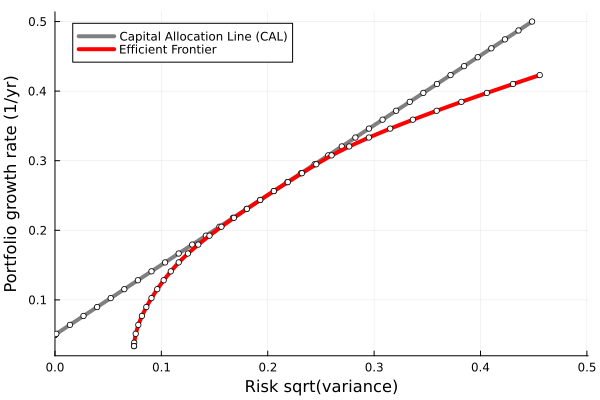

In [53]:
let
    plot(capital_allocation_line, lw=4, xlabel="Risk sqrt(variance)", 
        ylabel="Portfolio growth rate (1/yr)", fontsize=18, c=:gray, 
        xlim=(0.0, 1.1*maximum(capital_allocation_line).first), label="Capital Allocation Line (CAL)")
    scatter!(capital_allocation_line, label="", msc=:black, mc=:white, ms=3)
    
    plot!(efficient_frontier_sim, lw=4, xlabel="Risk sqrt(variance)", 
        ylabel="Portfolio growth rate (1/yr)", fontsize=18, label="Efficient Frontier", c=:red, 
        xlim=(0.0, 1.1*maximum(efficient_frontier_sim).first))
    scatter!(efficient_frontier_sim, label="", c=:white, mec=:red, ms=3)
end

## Task 3: Where is the tangent portfolio and what's in it?
The tangent portfolio is the point on the capital allocation line where the fraction of assets invested in the pool of risky assets is `1`, i.e., all of the investment budget is invested in risky assets. Let's estimate the expected return of the tangent portfolio $\mathcal{T}$ by trial and error: 
* `Procedure`: adjust the risk, solve the allocation problem and compute the fraction in risk assets $\theta$

In [55]:
problem_risk_free.R = 0.24845 # tangent 0.24845
allocation_sum_constraint = solve(problem_risk_free) |> x-> x["argmax"] |> x-> sum(x);
println("fraction in risk-free assets: $(1-allocation_sum_constraint), fraction in risky assets: $(allocation_sum_constraint)")

fraction in risk-free assets: -0.004710200804242337, fraction in risky assets: 1.0047102008042423


Let's solve the investment problem at the tangent portfolio:

In [57]:
tangent_portfolio_solution = nothing;
try
    tangent_portfolio_solution = solve(problem_risk_free)
catch err
    println("Hmmmm. That's not what we expected ...")
end

Dict{String, Any} with 4 entries:
  "argmax"          => [0.204542, -9.29679e-9, 0.357917, 0.0149946, -8.62147e-9…
  "reward"          => 0.24845
  "status"          => LOCALLY_SOLVED
  "objective_value" => 0.0391203

#### What's in the tangent portfolio?
`Unhide` the code block below to see how we constructed the portfolio allocation table for the single-index model tangent portfolio.
* __Summary__: For my choice of tickers, the portfolio allocation problem selected a combination of assets to hold in the tangent portfolio, where the investment budget was unequally divided between the tickers. The overall $\beta$ for the tangent portfolio was greater than the market portfolio, i.e., `SPY.`

In [59]:
let
    ω = tangent_portfolio_solution["argmax"];
    table_df = DataFrame();
    for i ∈ eachindex(my_low_correlation_ticker_array)
        ticker = my_low_correlation_ticker_array[i];
        ωᵢ = ω[i];
        row_data = (
            ticker = ticker,
            β = sim_model_dictionary[ticker].β,
            μ̂ = μ̂_sim[i],
            ω = round(ωᵢ, digits=4) |> abs,
        );
        push!(table_df,row_data)
    end

    beta_vec = table_df[:,:β] |> collect;
    w_vec = table_df[:,:ω] |> collect
    
    # compute the total -
    total = table_df[:,:ω] |> sum
    last_row = (
        ticker = "total",
        β = dot(beta_vec,w_vec),
        μ̂ = 0.0,
        ω = total,
    )
    push!(table_df,last_row)
    pretty_table(table_df, tf=tf_simple)
end

========= =========== ============= ==========
  ticker           β             μ̂         ω 
  String     Float64       Float64   Float64 
========= =========== ============= ==========
    AAPL     1.24019      0.249633    0.2045
     UNG    0.401587     -0.256232       0.0
    MSFT     1.13379       0.24601    0.3579
      KR    0.194428     0.0817963     0.015
    INTC     1.12753     0.0189146       0.0
     CPB    0.227696    -0.0142725       0.0
      MU     1.52694      0.108831       0.0
     GIS    0.297464     0.0168043       0.0
     AMD     1.67809      0.425158    0.2073
     SJM    0.293066    0.00370734       0.0
      GS     1.26915     0.0696787       0.0
     GLD   0.0822281     0.0714144      0.12
     BAC     1.32778     0.0206572       0.0
     CLX    0.243847    -0.0016578       0.0
     WFC     1.25441    -0.0371362       0.0
     CHD    0.332229       0.10931    0.0716
       C     1.48297    -0.0618607       0.0
     HRL      0.3087    -0.0189643       0.0
   

### Disclaimer and Risks
__This content is offered solely for training and informational purposes__. No offer or solicitation to buy or sell securities or derivative products or any investment or trading advice or strategy is made, given, or endorsed by the teaching team. 

__Trading involves risk__. Carefully review your financial situation before investing in securities, futures contracts, options, or commodity interests. Past performance, whether actual or indicated by historical tests of strategies, is no guarantee of future performance or success. Trading is generally inappropriate for someone with limited resources, investment or trading experience, or a low-risk tolerance.  Only risk capital that is not required for living expenses.

__You are fully responsible for any investment or trading decisions you make__. You should decide solely based on your financial circumstances, investment or trading objectives, risk tolerance, and liquidity needs.